## SNIPPET 6.1 Generating a Set of Informed, Redundant, and Noise Explanatory Variables

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.discrete.discrete_model as sm


In [24]:
def getTestData(n_features=100, n_informative=25, n_redundant=25, n_samples=10000, random_state=0, sigmaStd=0.) :
    # Generate a random dataset for a claasification problem
    
    from sklearn.datasets import make_classification
    np.random.seed(random_state)
    
    X, y = make_classification(n_samples = n_samples,
                                n_features = n_features - n_redundant, 
                                n_informative = n_informative, 
                                n_redundant = 0,
                                shuffle = False,
                                random_state = random_state)
    
    cols = ['I_'+str(i) for i in range(n_informative)]
    cols += ['N_' + str(i) for i in range(n_features - n_informative - n_redundant)]
    
    X, y = pd.DataFrame(X, columns = cols), pd.Series(y)
    
    i = np.random.choice(range(n_informative), size = n_redundant)
    
    for k,j in enumerate(i) :
        X['R_' + str(k)] = X['I_' + str(j)] + np.random.normal(size = X.shape[0]) * sigmaStd
        
    return X, y


In [27]:
X, y = getTestData(40, 5, 30, 10000, sigmaStd=.1)
ols = sm.Logit(y,X).fit()
ols.summary()

Optimization terminated successfully.
         Current function value: 0.380271
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9960
Method:                           MLE   Df Model:                           39
Date:                Tue, 28 Jul 2020   Pseudo R-squ.:                  0.4514
Time:                        00:22:03   Log-Likelihood:                -3802.7
converged:                       True   LL-Null:                       -6931.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
I_0            1.5619      0.814      1.918      0.055      -0.034       3.158
I_1           -2.3691      0.709     -3.343      0.001      -3.758      -0.980
I_2            0.8641      0.504      1.715      0.086      -0.123       1.851
I_3            1.8296      0.860      2.128      0.033       0.145       3.514
I_4           -0.4776      0.567     -0.842      0.400      -1.590       0.635
N_0            0.0244      0.028      0.857      0.391      -0.031       0.080
N_1           -0.0485      0.029     -1.671      0.095      -0.105       0.008
N_2            0.0367      0.029      1.262      0.207      -0.020       0.094
N_3           -0.0205      0.029     -0.706      0.480      -0.077       0.036
N_4           -0.0421      0.029     -1.459      0.145      -0.099       0.014
R_0            0.0271      0.287      0.094      0.925      -0.535       0.589
R_1           -0.0619      0.286     -0.216      0.829      -0.623       0.499
R_2            0.1759      0.286      0.616      0.538      -0.384       0.736
R_3           -0.3816      0.288     -1.326      0.185      -0.946       0.182
R_4           -0.0886      0.289     -0.307      0.759      -0.655       0.478
R_5            0.0035      0.286      0.012      0.990      -0.556       0.563
R_6           -0.1685      0.287     -0.587      0.557      -0.732       0.395
R_7           -0.0064      0.287     -0.022      0.982      -0.570       0.557
R_8           -0.3122      0.289     -1.080      0.280      -0.879       0.255
R_9           -0.4787      0.292     -1.637      0.102      -1.052       0.094
R_10          -0.2420      0.288     -0.840      0.401      -0.807       0.323
R_11           0.2955      0.286      1.034      0.301      -0.265       0.856
R_12          -0.0285      0.296     -0.096      0.923      -0.609       0.552
R_13           0.3914      0.288      1.360      0.174      -0.173       0.955
R_14          -0.2370      0.290     -0.817      0.414      -0.805       0.331
R_15           0.1278      0.292      0.438      0.661      -0.444       0.699
R_16          -0.1507      0.290     -0.520      0.603      -0.719       0.417
R_17          -0.5064      0.288     -1.757      0.079      -1.071       0.059
R_18           0.2050      0.288      0.711      0.477      -0.360       0.770
R_19          -0.0950      0.288     -0.330      0.741      -0.659       0.469
R_20          -0.2437      0.286     -0.851      0.395      -0.805       0.317
R_21          -0.0479      0.293     -0.163      0.870      -0.623       0.527
R_22           0.1300      0.287      0.452      0.651      -0.433       0.693
R_23           0.4978      0.291      1.713      0.087      -0.072       1.067
R_24          -0.2049      0.290     -0.706      0.480      -0.774       0.364
R_25          -0.0985      0.289     -0.341      0.733      -0.665       0.468
R_26          -0.2239      0.289     -0.776      0.438      -0.789       0.342
R_27           0.6949      0.289      2.406      0.016       0.129       1.261
R_

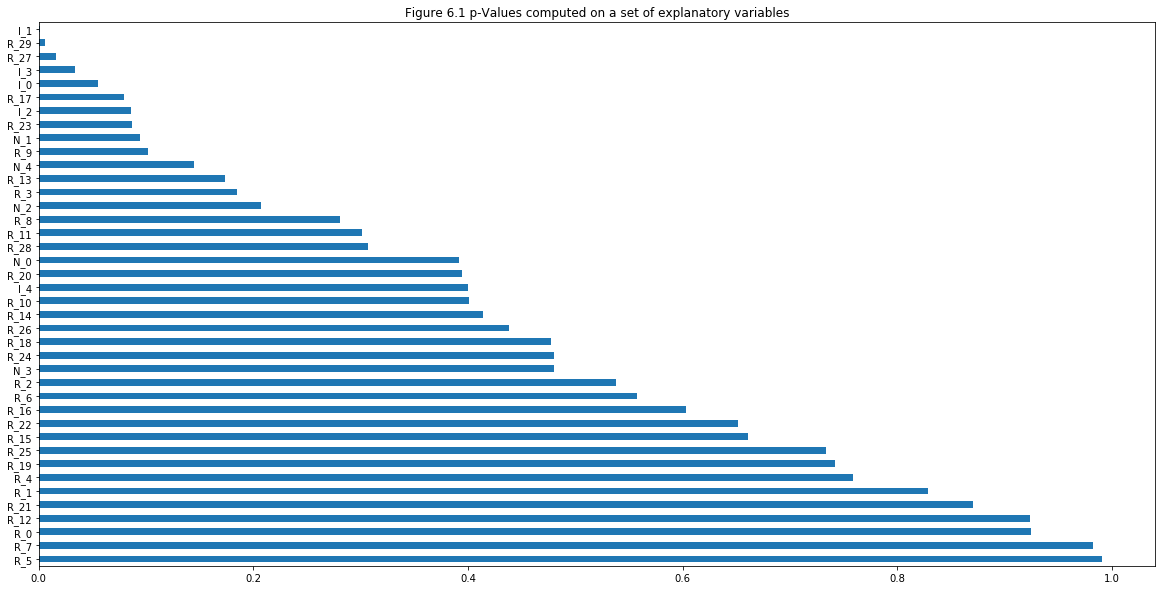

In [62]:
plot_data = ols.pvalues.sort_values(ascending=False)
plot_data.plot(kind='barh', figsize=(20,10), title="Figure 6.1 p-Values computed on a set of explanatory variables")
plt.show()

## SNIPPET 6.2 Implementation of an Ensemble MDI Method

In [64]:
def featImpMDI(fit, featNames) :
    
    # feat imoprtance based on IS mean impurity reduction
    
    df0 = {i : tree.feature_importances_ for i, tree in enumerate(fit.estimators_)}
    
    df0 = pd.DataFrame.from_dict(df0, orient='index')
    
    df0.columns = featNames
    df0= df0.replace(0, np.nan) # because max_features=1
    
    imp = pd.concat({'mean' : df0.mean(), 'std':df0.std() * df0.shape[0]**-.5}, axis=1) #CLT
    
    imp /= imp['mean'].sum()
    return imp


In [65]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

X, y = getTestData(40, 5, 30, 10000, sigmaStd=.1)

In [66]:
clf = DecisionTreeClassifier(criterion='entropy', 
                             max_features = 1, 
                             class_weight='balanced', 
                             min_weight_fraction_leaf=0)

clf = BaggingClassifier(base_estimator=clf, 
                        n_estimators = 1000, 
                        max_features = 1., 
                        max_samples = 1., 
                        oob_score=False)

fit = clf.fit(X,y)
imp = featImpMDI(fit, featNames=X.columns)

In [67]:
imp

,mean,std
I_0,0.021041,0.000416
I_1,0.045226,0.001614
I_2,0.035870,0.000694
I_3,0.014686,0.000145
I_4,0.032431,0.000808
N_0,0.011530,0.000086
N_1,0.011581,0.000087
N_2,0.011416,0.000088
N_3,0.011480,0.000087
N_4,0.011592,0.000088


<ErrorbarContainer object of 3 artists>

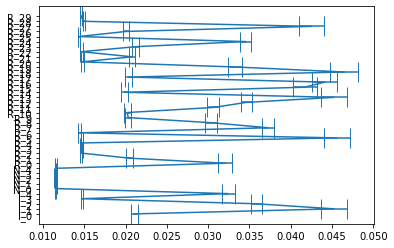

In [81]:
plt.errorbar(x = imp['mean'], xerr = imp['std'], y= imp.index.tolist(), capsize = 10)

## SNIPPET 6.3 Implementation of MDA

In [ ]:
def featImpMDA(clf, X, y, n_splits=10) :
    return